<a href="https://colab.research.google.com/github/peterbabulik/P-Bit-Simulations/blob/main/P_Bit_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- STARTING PARTITION OPTIMIZATION (500 items) ---
Initial Difference: 13807
Final Difference: 1


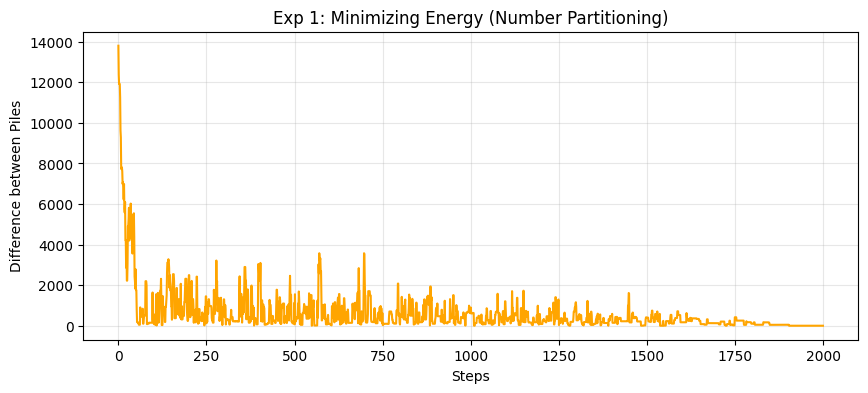


--- STARTING MEMORY RESTORATION ---


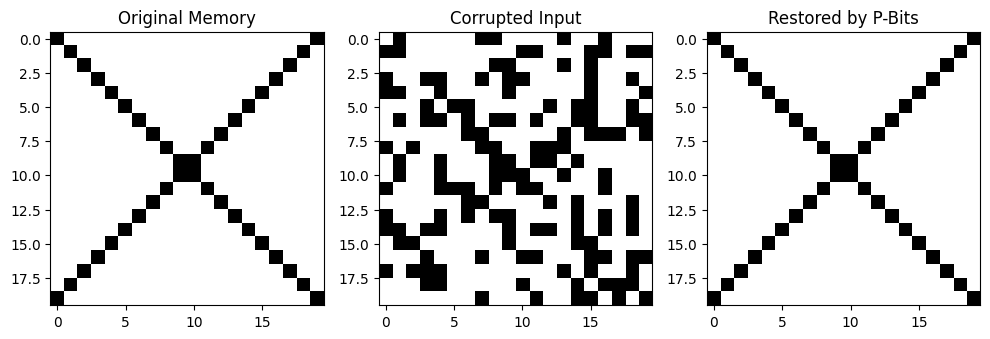

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# EXPERIMENT 1: THE PERFECT SPLIT (Optimization)
# ==========================================

class PartitionSolver:
    def __init__(self, n_numbers=1000): # Let's use 1000 for clear visualization
        # 1. Generate random weights (The Problem)
        self.n = n_numbers
        self.weights = np.random.randint(1, 1000, size=self.n)

        # 2. Initialize P-Bits (The Solvers)
        # State -1 = Pile A, State +1 = Pile B
        self.state = np.random.choice([-1, 1], size=self.n)

        self.best_diff = float('inf')
        self.history = []

    def energy(self):
        """
        The Energy is the squared difference between the two piles.
        Goal: Energy = 0.
        """
        pile_A = self.weights[self.state == -1]
        pile_B = self.weights[self.state == 1]
        diff = np.abs(np.sum(pile_A) - np.sum(pile_B))
        return diff

    def run_annealing(self, steps=1000):
        print(f"--- STARTING PARTITION OPTIMIZATION ({self.n} items) ---")
        print(f"Initial Difference: {self.energy()}")

        current_energy = self.energy()

        for i in range(steps):
            # Annealing Schedule: Temperature drops over time
            temperature = max(1.0, 1000 * (1 - i/steps))

            # 1. Pick a random bit to try flipping
            idx = np.random.randint(0, self.n)

            # 2. Calculate Energy Change (Delta E)
            # Shortcut math: How much does the difference change if we swap piles?
            # We use a full calculation here for clarity
            old_state = self.state[idx]
            self.state[idx] *= -1 # Flip it
            new_energy = self.energy()

            delta_E = new_energy - current_energy

            # 3. Thermodynamic Decision (Metropolis Algorithm)
            # If it improves (delta_E < 0), accept.
            # If it gets worse, accept with probability e^(-delta_E / T)
            # This allows it to "jump" out of local traps.

            if delta_E < 0 or np.random.rand() < np.exp(-delta_E / temperature):
                current_energy = new_energy
                if current_energy < self.best_diff:
                    self.best_diff = current_energy
            else:
                self.state[idx] *= -1 # Revert flip (Reject)

            self.history.append(current_energy)

        print(f"Final Difference: {self.best_diff}")
        return self.history

# ==========================================
# EXPERIMENT 2: ASSOCIATIVE MEMORY (Restoration)
# ==========================================

class HopfieldMemory:
    def __init__(self, size=20): # 20x20 Grid = 400 Neurons
        self.size = size
        self.n_neurons = size * size
        self.weights = np.zeros((self.n_neurons, self.n_neurons))

    def train(self, pattern):
        """
        Hebbian Learning: "Neurons that fire together, wire together."
        We sculpt the energy landscape so this pattern is a minimum.
        """
        flat_p = pattern.flatten()
        # Outer product creates the interaction matrix
        self.weights += np.outer(flat_p, flat_p)
        np.fill_diagonal(self.weights, 0) # No self-connection

    def reconstruct(self, noisy_pattern, steps=5):
        state = noisy_pattern.flatten().copy()
        history = [state.reshape(self.size, self.size)]

        # Asynchronous Update
        indices = np.arange(self.n_neurons)

        for _ in range(steps):
            np.random.shuffle(indices)
            for i in indices:
                # Calculate resonance with all other neurons
                # Field = Sum(Weights * Neighbors)
                field = np.dot(self.weights[i], state)

                # Update State: If field > 0, state = 1, else -1
                state[i] = 1 if field > 0 else -1

            history.append(state.copy().reshape(self.size, self.size))

        return history

# ==========================================
# RUNNING THE EXPERIMENTS
# ==========================================

# --- EXP 1: PARTITIONING ---
solver = PartitionSolver(n_numbers=500)
loss_curve = solver.run_annealing(steps=2000)

plt.figure(figsize=(10, 4))
plt.plot(loss_curve, color='orange')
plt.title("Exp 1: Minimizing Energy (Number Partitioning)")
plt.xlabel("Steps")
plt.ylabel("Difference between Piles")
plt.grid(True, alpha=0.3)
plt.show()

# --- EXP 2: HOPFIELD MEMORY ---
print("\n--- STARTING MEMORY RESTORATION ---")

# 1. Create a Pattern (A Cross)
size = 20
pattern = -1 * np.ones((size, size))
for i in range(size):
    pattern[i, i] = 1       # Diagonal \
    pattern[i, size-1-i] = 1 # Diagonal /

# 2. Train the Network
memory = HopfieldMemory(size)
memory.train(pattern)

# 3. Corrupt the Pattern (Add Noise)
noisy_pattern = pattern.copy()
noise_amount = 0.3 # Flip 30% of bits
mask = np.random.rand(size, size) < noise_amount
noisy_pattern[mask] *= -1

# 4. Run the P-Bit Swarm to Heal it
reconstruction_frames = memory.reconstruct(noisy_pattern, steps=4)

# 5. Visualize
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(pattern, cmap='binary')
axes[0].set_title("Original Memory")
axes[1].imshow(noisy_pattern, cmap='binary')
axes[1].set_title("Corrupted Input")
axes[2].imshow(reconstruction_frames[-1], cmap='binary')
axes[2].set_title("Restored by P-Bits")
plt.show()